In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

In [2]:
def compute_iou(box1, box2):
    """
    Compute IoU between two bounding boxes.
    
    Args:
        box1, box2: Each box should be in format [x_min, y_min, x_max, y_max]
    
    Returns:
        IoU value between 0 and 1
    """
    # Get the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    
    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Compute intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Compute areas of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Compute IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou

In [3]:
def compute_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    """
    Compute precision and recall values for different confidence thresholds.
    
    Args:
        gt_boxes: List of ground truth boxes, each [x_min, y_min, x_max, y_max]
        pred_boxes: List of predicted boxes, each [x_min, y_min, x_max, y_max]
        pred_scores: Confidence scores for each predicted box
        iou_threshold: IoU threshold for considering a detection as true positive
    
    Returns:
        precision: List of precision values
        recall: List of recall values
        thresholds: List of confidence threshold values
    """
    # Sort predictions by confidence score (highest first)
    sorted_indices = np.argsort(pred_scores)[::-1]
    sorted_boxes = [pred_boxes[i] for i in sorted_indices]
    sorted_scores = [pred_scores[i] for i in sorted_indices]
    
    # Initialize lists to keep track of true positives and false positives
    true_positives = []
    false_positives = []
    
    # Keep track of which gt boxes have been matched
    gt_matched = [False] * len(gt_boxes)
    
    # Process each prediction
    for pred_box in sorted_boxes:
        # Find the best matching ground truth box
        best_iou = 0
        best_gt_idx = -1
        
        for gt_idx, gt_box in enumerate(gt_boxes):
            if not gt_matched[gt_idx]:  # Consider only unmatched gt boxes
                iou = compute_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
        
        # Check if the best match exceeds the IoU threshold
        if best_iou >= iou_threshold and best_gt_idx != -1:
            true_positives.append(1)
            false_positives.append(0)
            gt_matched[best_gt_idx] = True  # Mark the gt box as matched
        else:
            true_positives.append(0)
            false_positives.append(1)
    
    # Calculate cumulative precision and recall
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)
    recalls = tp_cumsum / len(gt_boxes) if len(gt_boxes) > 0 else np.zeros_like(tp_cumsum)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
    
    # Add sentinel values to ensure proper computation
    precisions = np.concatenate(([1.0], precisions))
    recalls = np.concatenate(([0.0], recalls))
    thresholds = np.concatenate(([sorted_scores[0] + 1], sorted_scores))
    
    return precisions, recalls, thresholds

In [4]:
def voc_ap_11_point(precisions, recalls):
    """
    Compute Average Precision using Pascal VOC 11-point interpolation method.
    
    Args:
        precisions: List of precision values
        recalls: List of recall values
    
    Returns:
        AP: Average Precision value
    """
    # 11 equally spaced recall points [0.0, 0.1, 0.2, ..., 1.0]
    recall_points = np.linspace(0, 1, 11)
    
    # Compute precision at each recall point
    ap = 0
    for r in recall_points:
        # Find all precisions where recall >= r
        valid_precisions = precisions[recalls >= r]
        
        # If no valid precisions, use 0
        if len(valid_precisions) == 0:
            p = 0
        else:
            # Use max precision at this recall level or greater
            p = np.max(valid_precisions)
        
        ap += p / 11.0
    
    return ap

In [5]:
def coco_ap_101_point(precisions, recalls):
    """
    Compute Average Precision using COCO 101-point interpolation method.
    
    Args:
        precisions: List of precision values
        recalls: List of recall values
    
    Returns:
        AP: Average Precision value
    """
    # 101 equally spaced recall points [0.0, 0.01, 0.02, ..., 1.0]
    recall_points = np.linspace(0, 1, 101)
    
    # Compute precision at each recall point
    ap = 0
    for r in recall_points:
        # Find all precisions where recall >= r
        valid_precisions = precisions[recalls >= r]
        
        # If no valid precisions, use 0
        if len(valid_precisions) == 0:
            p = 0
        else:
            # Use max precision at this recall level or greater
            p = np.max(valid_precisions)
        
        ap += p / 101.0
    
    return ap

In [6]:
def area_under_curve_ap(precisions, recalls):
    """
    Compute Average Precision as the Area under Precision-Recall Curve.
    
    Args:
        precisions: List of precision values
        recalls: List of recall values
    
    Returns:
        AP: Average Precision value
    """
    # Make sure recalls are sorted
    sorted_indices = np.argsort(recalls)
    recalls = recalls[sorted_indices]
    precisions = precisions[sorted_indices]
    
    # Calculate the area under the curve using the trapezoidal rule
    ap = 0
    for i in range(1, len(recalls)):
        ap += (recalls[i] - recalls[i-1]) * (precisions[i] + precisions[i-1]) / 2
    
    return ap

In [7]:
def generate_random_boxes(num_boxes, image_size=100, box_size=20):
    """
    Generate random boxes within an image.
    
    Args:
        num_boxes: Number of boxes to generate
        image_size: Size of the image (square)
        box_size: Size of the boxes (square)
    
    Returns:
        boxes: List of boxes in format [x_min, y_min, x_max, y_max]
    """
    boxes = []
    for _ in range(num_boxes):
        # Generate random top-left corner
        x_min = random.randint(0, image_size - box_size)
        y_min = random.randint(0, image_size - box_size)
        
        # Calculate bottom-right corner
        x_max = x_min + box_size
        y_max = y_min + box_size
        
        boxes.append([x_min, y_min, x_max, y_max])
    
    return boxes

In [8]:
def generate_synthetic_dataset(num_images=10, num_boxes=10, image_size=100, box_size=20):
    """
    Generate a synthetic dataset with ground truth and predicted boxes.
    
    Args:
        num_images: Number of images to generate
        num_boxes: Number of boxes per image
        image_size: Size of each image (square)
        box_size: Size of each box (square)
    
    Returns:
        dataset: List of dictionaries, each containing gt_boxes, pred_boxes, and pred_scores
    """
    dataset = []
    
    for _ in range(num_images):
        # Generate ground truth boxes
        gt_boxes = generate_random_boxes(num_boxes, image_size, box_size)
        
        # Generate predicted boxes (with some noise)
        pred_boxes = []
        pred_scores = []
        
        # Generate true-positive predictions (slightly shifted ground truth boxes)
        for box in gt_boxes:
            # Add random shift to the box (±5 pixels)
            shift_x = random.randint(-5, 5)
            shift_y = random.randint(-5, 5)
            
            # Create a new box with the shift
            new_box = [
                max(0, box[0] + shift_x),
                max(0, box[1] + shift_y),
                min(image_size, box[2] + shift_x),
                min(image_size, box[3] + shift_y)
            ]
            
            pred_boxes.append(new_box)
            # Give true positives higher confidence scores (0.5-1.0)
            pred_scores.append(random.uniform(0.5, 1.0))
        
        # Generate some false-positive predictions
        num_fp = random.randint(0, 5)
        fp_boxes = generate_random_boxes(num_fp, image_size, box_size)
        pred_boxes.extend(fp_boxes)
        # Give false positives lower confidence scores (0.1-0.6)
        pred_scores.extend([random.uniform(0.1, 0.6) for _ in range(num_fp)])
        
        dataset.append({
            'gt_boxes': gt_boxes,
            'pred_boxes': pred_boxes,
            'pred_scores': pred_scores
        })
    
    return dataset

In [9]:
def evaluate_ap(dataset, iou_threshold=0.5):
    """
    Evaluate Average Precision using all three methods on the given dataset.
    
    Args:
        dataset: List of dictionaries, each containing gt_boxes, pred_boxes, and pred_scores
        iou_threshold: IoU threshold for considering a detection as true positive
    
    Returns:
        results: Dictionary containing AP values for each method
    """
    # Initialize variables to accumulate precision and recall values
    all_precisions = []
    all_recalls = []
    
    # Process each image
    for data in dataset:
        gt_boxes = data['gt_boxes']
        pred_boxes = data['pred_boxes']
        pred_scores = data['pred_scores']
        
        # Compute precision and recall
        precisions, recalls, _ = compute_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold)
        
        # Accumulate values
        all_precisions.append(precisions)
        all_recalls.append(recalls)
    
    # Compute average precisions
    voc_aps = []
    coco_aps = []
    auc_aps = []
    
    for precisions, recalls in zip(all_precisions, all_recalls):
        voc_aps.append(voc_ap_11_point(precisions, recalls))
        coco_aps.append(coco_ap_101_point(precisions, recalls))
        auc_aps.append(area_under_curve_ap(precisions, recalls))
    
    # Compute mean AP for each method
    results = {
        'VOC 11-point AP': np.mean(voc_aps),
        'COCO 101-point AP': np.mean(coco_aps),
        'Area under curve AP': np.mean(auc_aps)
    }
    
    return results

In [10]:
def visualize_boxes(image_idx, dataset, figsize=(10, 10)):
    """
    Visualize ground truth and predicted boxes for a specific image.
    
    Args:
        image_idx: Index of the image in the dataset
        dataset: List of dictionaries containing gt_boxes and pred_boxes
        figsize: Figure size
    """
    # Get data for the specified image
    data = dataset[image_idx]
    gt_boxes = data['gt_boxes']
    pred_boxes = data['pred_boxes']
    pred_scores = data['pred_scores']
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set the limits to the image size
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    # Plot ground truth boxes in green
    for box in gt_boxes:
        x, y, x2, y2 = box
        width = x2 - x
        height = y2 - y
        rect = Rectangle((x, y), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    
    # Plot predicted boxes in red with confidence score
    for box, score in zip(pred_boxes, pred_scores):
        x, y, x2, y2 = box
        width = x2 - x
        height = y2 - y
        rect = Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f'{score:.2f}', color='r', fontsize=10, va='bottom')
    
    ax.set_title(f'Image {image_idx+1}: Green=GT, Red=Pred')
    plt.gca().invert_yaxis()  # Invert y-axis to match standard image coordinates
    plt.show()

In [11]:
def visualize_precision_recall_curve(dataset, iou_threshold=0.5):
    """
    Visualize precision-recall curves for the dataset.
    
    Args:
        dataset: List of dictionaries containing gt_boxes, pred_boxes, and pred_scores
        iou_threshold: IoU threshold
    """
    # Combine all predictions across images
    all_gt_boxes = []
    all_pred_boxes = []
    all_pred_scores = []
    
    for data in dataset:
        all_gt_boxes.extend(data['gt_boxes'])
        all_pred_boxes.extend(data['pred_boxes'])
        all_pred_scores.extend(data['pred_scores'])
    
    # Compute precision and recall
    precisions, recalls, _ = compute_precision_recall(all_gt_boxes, all_pred_boxes, all_pred_scores, iou_threshold)
    
    # Calculate AP using different methods
    voc_ap = voc_ap_11_point(precisions, recalls)
    coco_ap = coco_ap_101_point(precisions, recalls)
    auc_ap = area_under_curve_ap(precisions, recalls)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Plot precision-recall curve
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    
    # Plot interpolated precision for VOC 11-point method
    recall_points = np.linspace(0, 1, 11)
    voc_precisions = []
    
    for r in recall_points:
        valid_precisions = precisions[recalls >= r]
        p = np.max(valid_precisions) if len(valid_precisions) > 0 else 0
        voc_precisions.append(p)
    
    plt.step(recall_points, voc_precisions, 'g--', where='post', label='VOC 11-point interpolation')
    
    # Add details to the plot
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (IoU={iou_threshold})')
    plt.grid(True)
    plt.axis([0, 1, 0, 1.05])
    
    # Add AP values to the legend
    plt.legend([
        f'Precision-Recall Curve',
        f'VOC 11-point (AP={voc_ap:.4f})'
    ])
    
    # Add a text box with all AP values
    textstr = '\n'.join((
        f'VOC 11-point AP: {voc_ap:.4f}',
        f'COCO 101-point AP: {coco_ap:.4f}',
        f'Area under curve AP: {auc_ap:.4f}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.25, textstr, transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top', bbox=props)
    
    plt.show()

# Part 5: Run the Experiment

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate synthetic dataset with 10 images, 10 GT boxes and varying number of predicted boxes
dataset = generate_synthetic_dataset(num_images=10, num_boxes=10, image_size=100, box_size=20)

# Evaluate AP50 using all methods
results = evaluate_ap(dataset, iou_threshold=0.5)

Average Precision Results (IoU threshold = 0.5):
VOC 11-point AP: 0.7909
COCO 101-point AP: 0.7819
Area under curve AP: 0.7343

Visualizing boxes for the first 3 images:


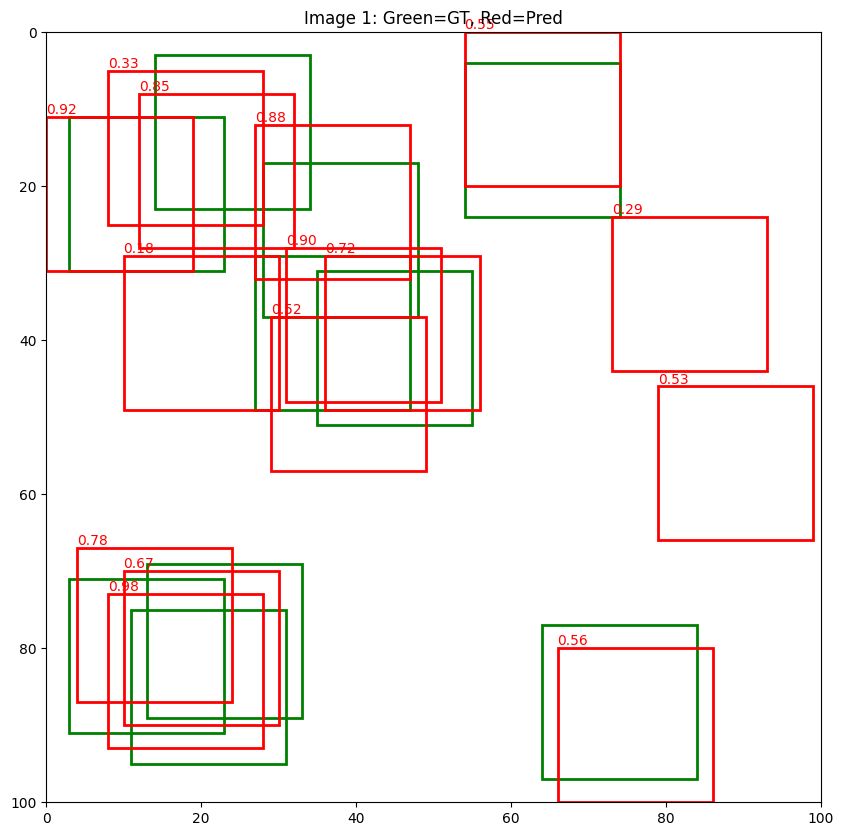

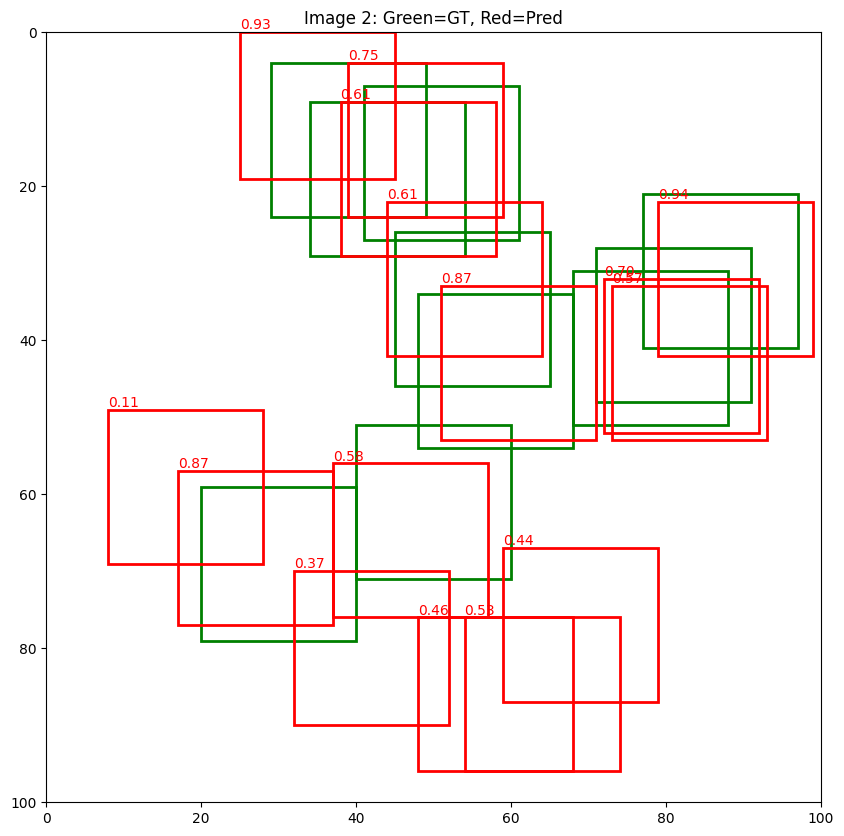

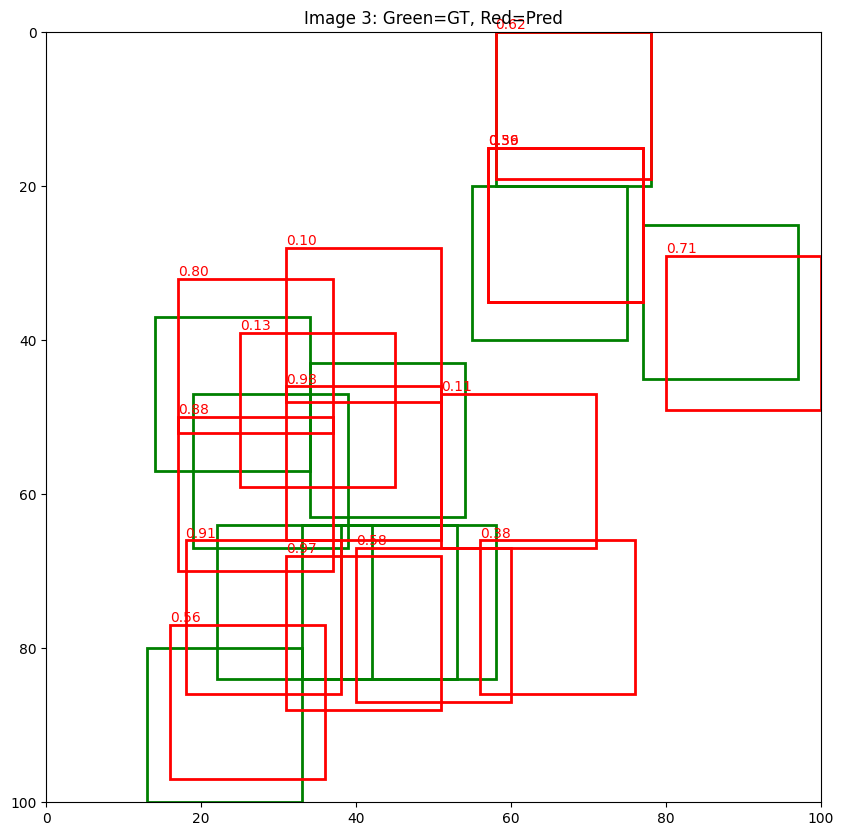


Precision-Recall Curve:


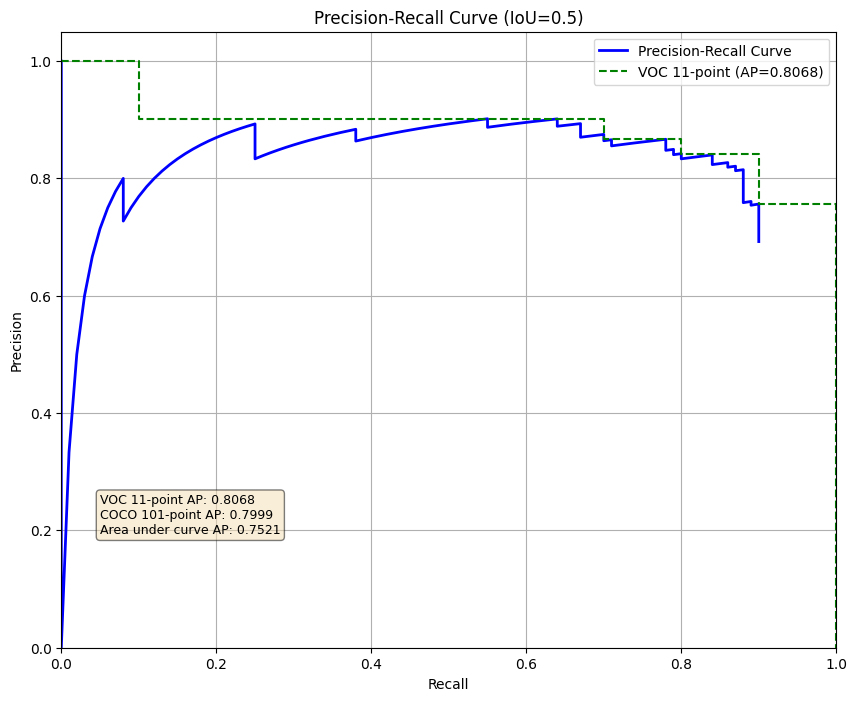

In [12]:
# Display results
print("Average Precision Results (IoU threshold = 0.5):")
for method, ap in results.items():
    print(f"{method}: {ap:.4f}")

# Visualize some examples
print("\nVisualizing boxes for the first 3 images:")
for i in range(3):
    visualize_boxes(i, dataset)

# Visualize precision-recall curve
print("\nPrecision-Recall Curve:")
visualize_precision_recall_curve(dataset, iou_threshold=0.5)

In [13]:
# Conclusion
print("\nAnalysis:")
print("The three methods of computing AP give slightly different results because:")
print("1. VOC 11-point interpolation samples precision at 11 fixed recall points (0, 0.1, ..., 1.0)")
print("2. COCO 101-point interpolation uses 101 recall points for finer granularity")
print("3. Area under curve method computes the actual area under the precision-recall curve")
print("\nThe COCO method is generally more accurate than VOC due to more sampling points.")
print("The area under curve method provides the most accurate representation of the full PR curve.")


Analysis:
The three methods of computing AP give slightly different results because:
1. VOC 11-point interpolation samples precision at 11 fixed recall points (0, 0.1, ..., 1.0)
2. COCO 101-point interpolation uses 101 recall points for finer granularity
3. Area under curve method computes the actual area under the precision-recall curve

The COCO method is generally more accurate than VOC due to more sampling points.
The area under curve method provides the most accurate representation of the full PR curve.
